In [12]:
# Set Up Drive, Kaggle  and Download Dataset
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# verify kaggle works
!kaggle datasets list

# Download the dataset (12K images)
!kaggle datasets download -d abdelrahmanemad2199/corn-or-maize-leaf-disease-dataset

# Unzip the dataset (replace 'dataset-identifier.zip' with the actual downloaded zip file name
!unzip corn-or-maize-leaf-disease-dataset.zip -d /content/dataset



Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8da48548-461c-4574-9435-74310d8207a3___RS_GLSp 4387_270deg.JPG  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8da48548-461c-4574-9435-74310d8207a3___RS_GLSp 4387_90deg.JPG  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8da48548-461c-4574-9435-74310d8207a3___RS_GLSp 4387_new30degFlipLR.JPG  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy_270deg.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy_90deg.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy_new30degFlipLR.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/9043a294-8d22-405f-add1-7e5

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Move the dataset to your Google Drive
# !mv /content/dataset /content/drive/MyDrive/

Mounted at /content/drive


In [13]:
import tensorflow as tf
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Dataset directory and parameters
dataset_dir = '/content/dataset/corn/data'
target_size = (256, 256)
batch_size = 32

# Get class names and encode labels
class_names = os.listdir(dataset_dir)
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# Load file paths and labels
file_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))
        labels.append(class_name)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Encode labels
def encode_labels(labels):
    return label_encoder.transform(labels)

# Split data into training + validation (90%) and test (10%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.1, stratify=labels, random_state=42
)

# Split training + validation into training (70%) and validation (20%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42
)

# Update dataset creation function
def load_and_preprocess_image(file_path, target_size):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image

def create_dataset(file_paths, labels, batch_size, is_training):
    labels = encode_labels(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x, target_size), y))
    if is_training:
        dataset = dataset.map(lambda x, y: (augment_image(x), y))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(train_paths, train_labels, batch_size, is_training=True)
validation_dataset = create_dataset(val_paths, val_labels, batch_size, is_training=False)
test_dataset = create_dataset(test_paths, test_labels, batch_size, is_training=False)



# Check dataset formats
for images, labels in train_dataset.take(1):
    print('Train images shape:', images.shape)
    print('Train labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())

for images, labels in validation_dataset.take(1):
    print('Validation images shape:', images.shape)
    print('Validation labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())


Train images shape: (32, 256, 256, 3)
Train labels shape: (32,)
Sample labels: [3 3 2 3 1 3 3 3 3 3 3 1 0 3 3 3 1 2 1 2 3 1 2 3 1 1 3 3 3 0 0 0]
Validation images shape: (32, 256, 256, 3)
Validation labels shape: (32,)
Sample labels: [3 0 3 3 0 1 2 1 3 1 3 0 1 3 1 2 2 2 3 1 3 1 3 0 0 3 3 0 0 2 3 3]


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get class distribution
def get_class_distribution(labels):
    class_counts = pd.Series(labels).value_counts()
    return class_counts

# Get class distributions for train, validation, and test sets
train_class_counts = get_class_distribution(train_labels)
val_class_counts = get_class_distribution(val_labels)
test_class_counts = get_class_distribution(test_labels)

print("Train class distribution:\n", train_class_counts)
print("Validation class distribution:\n", val_class_counts)
print("Test class distribution:\n", test_class_counts)


Train class distribution:
 Common_Rust       2574
Healthy           2503
Blight            1975
Gray_Leaf_Spot    1847
Name: count, dtype: int64
Validation class distribution:
 Common_Rust       644
Healthy           625
Blight            494
Gray_Leaf_Spot    462
Name: count, dtype: int64
Test class distribution:
 Common_Rust       358
Healthy           348
Blight            274
Gray_Leaf_Spot    256
Name: count, dtype: int64


<ipython-input-15-779b63a368a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


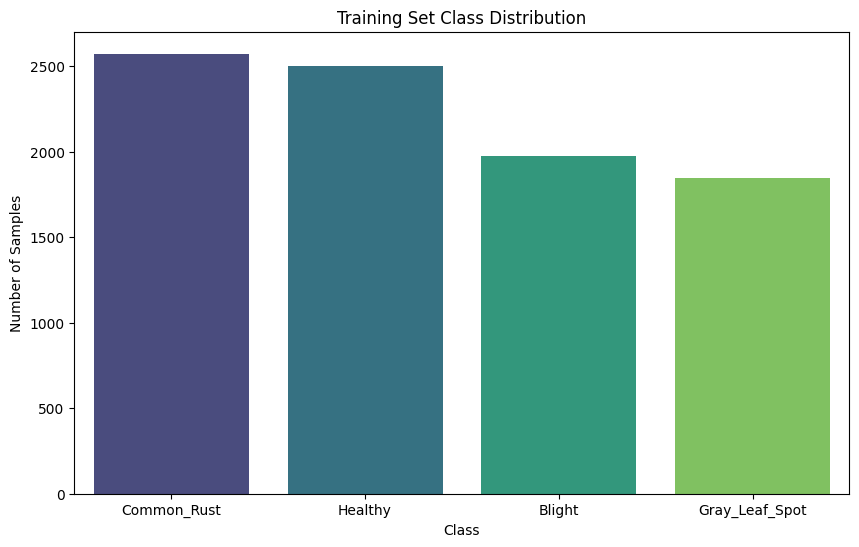

<ipython-input-15-779b63a368a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


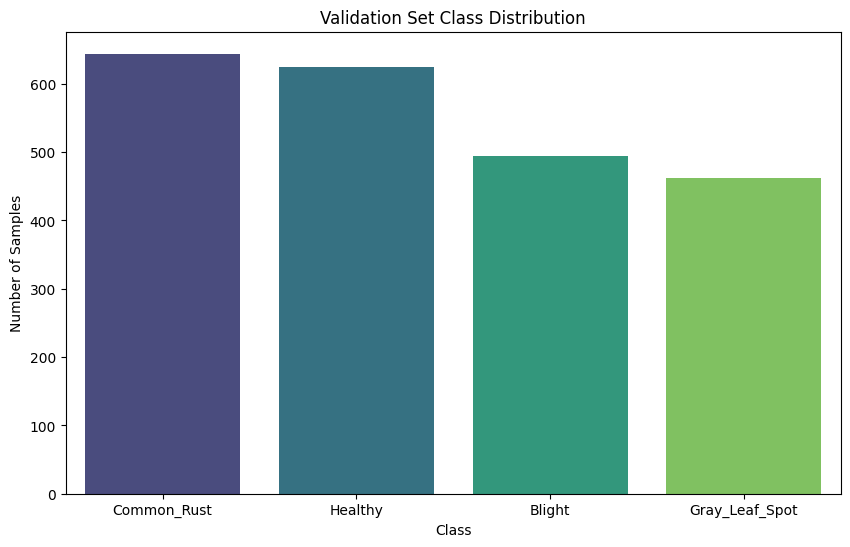

<ipython-input-15-779b63a368a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


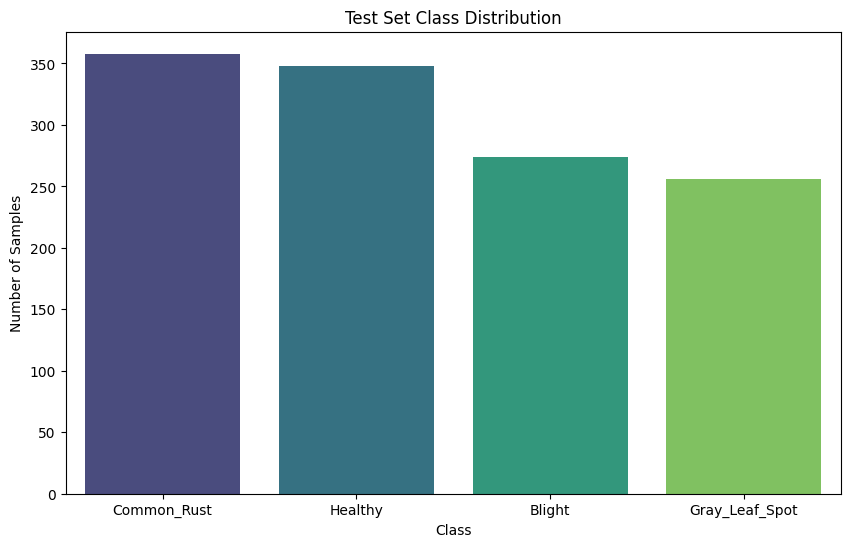

In [15]:
# Function to plot class distribution
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Plot distributions
plot_class_distribution(train_class_counts, "Training Set Class Distribution")
plot_class_distribution(val_class_counts, "Validation Set Class Distribution")
plot_class_distribution(test_class_counts, "Test Set Class Distribution")


Error loading image /content/dataset/corn/data/Gray_Leaf_Spot/038464d1-47a9-4169-afb1-72c87e568a95___RS_GLSp 4480_new30degFlipLR.JPG: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 804 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Error loading image /content/dataset/corn/data/Blight/bd30a64c-92a4-422c-9bc1-7752f09e2809___RS_NLB  4507 copy_flipTB.jpg: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 9909 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Error loading image /content/dataset/corn/data/Healthy/18a8a550-10c1-47e0-8049-fba853f92918___R.S_HL 5497 copy_flipLR.jpg: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 5445 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Error loading image /content/dataset/corn/data/Gray_Leaf_Spot/f8101df7-db23-4241-

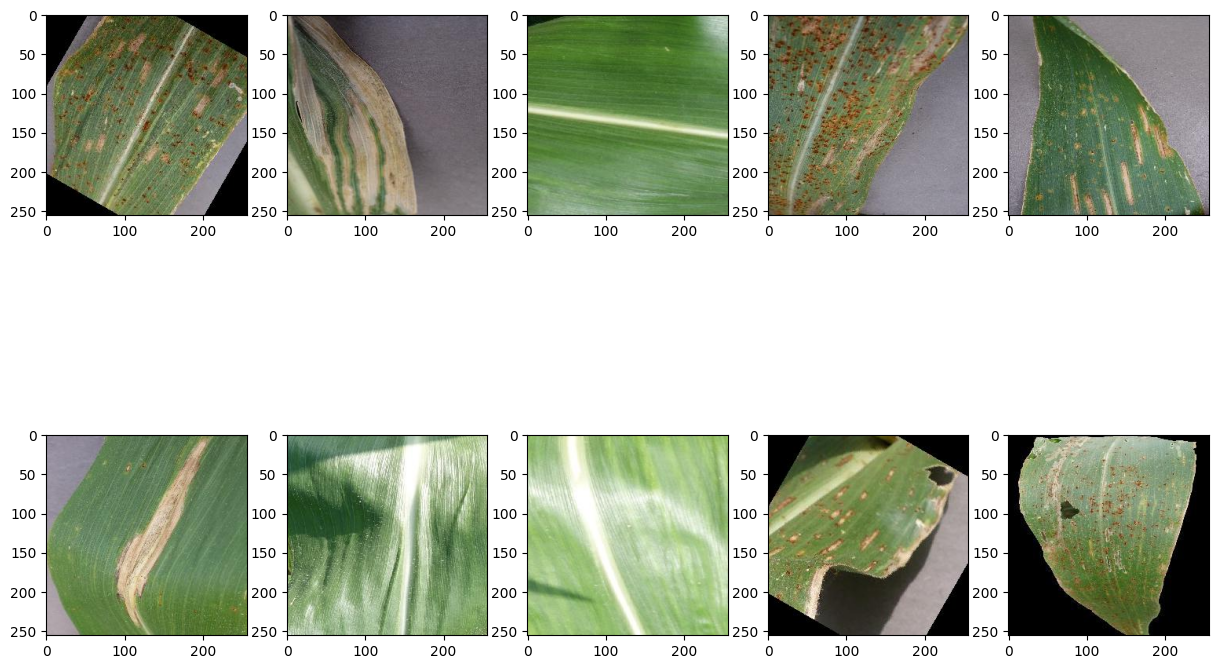

In [23]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_samples(file_paths, labels, num_samples=10):
    dataset_size = len(file_paths)
    num_samples = min(num_samples, dataset_size)  # Ensure we don't sample more than available

    # Randomly sample indices without replacement within the valid range
    random_indices = random.sample(range(dataset_size), num_samples)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        try:
            plt.subplot(2, 5, i + 1)
            img = mpimg.imread(file_paths[idx])
            plt.imshow(img)
            plt.title(labels[idx].decode('utf-8'))
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {file_paths[idx]}: {e}")
    plt.show()

# Show random samples from the dataset
show_random_samples(file_paths, labels, num_samples=10)


In [24]:
def print_summary_statistics(class_counts):
    print(f"Number of samples per class:\n{class_counts}")

print_summary_statistics(train_class_counts)
print_summary_statistics(val_class_counts)
print_summary_statistics(test_class_counts)


Number of samples per class:
Common_Rust       2574
Healthy           2503
Blight            1975
Gray_Leaf_Spot    1847
Name: count, dtype: int64
Number of samples per class:
Common_Rust       644
Healthy           625
Blight            494
Gray_Leaf_Spot    462
Name: count, dtype: int64
Number of samples per class:
Common_Rust       358
Healthy           348
Blight            274
Gray_Leaf_Spot    256
Name: count, dtype: int64


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load and prepare the base model with MobileNetV2
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes for maize leaf diseases
])

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
optimizer = Nadam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

<ipython-input-25-f8e18460ead5>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


In [26]:
# Training

import os

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/a2.keras', save_best_only=True, )

# Check if the checkpoint file exists
if os.path.exists('/content/drive/MyDrive/a2.keras'):
    # Load the best weights saved by the checkpoint
    model.load_weights('/content/drive/MyDrive/a2.keras')
    print("Best model weights loaded successfully!")
else:
    print("No previous checkpoint found. Training from scratch...")


# Train the model

for images, labels in train_dataset.take(1):
    print('Train images shape:', images.shape)
    print('Train labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())

for images, labels in validation_dataset.take(1):
    print('Validation images shape:', images.shape)
    print('Validation labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)


No previous checkpoint found. Training from scratch...
Train images shape: (32, 256, 256, 3)
Train labels shape: (32,)
Sample labels: [3 3 2 3 1 3 3 3 3 3 3 1 0 3 3 3 1 2 1 2 3 1 2 3 1 1 3 3 3 0 0 0]
Validation images shape: (32, 256, 256, 3)
Validation labels shape: (32,)
Sample labels: [3 0 3 3 0 1 2 1 3 1 3 0 1 3 1 2 2 2 3 1 3 1 3 0 0 3 3 0 0 2 3 3]
Epoch 1/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 54s 148ms/step - accuracy: 0.7624 - loss: 0.5995 - val_accuracy: 0.8535 - val_loss: 0.3023
Epoch 2/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.8571 - loss: 0.3436 - val_accuracy: 0.8908 - val_loss: 0.2664
Epoch 3/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.8819 - loss: 0.2975 - val_accuracy: 0.8962 - val_loss: 0.2323
Epoch 4/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.8790 - loss: 0.2876 - val_accuracy: 0.9088 - val_loss: 0.2334
Epoch 5/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.8865 - loss: 0.2673 - val_accuracy: 0.9106 - val_los

In [27]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9447 - loss: 0.1371
Test Loss: 0.14690330624580383
Test Accuracy: 0.9417475461959839


In [28]:
# save the model

model.save('/content/drive/MyDrive/maizespy_model.keras')


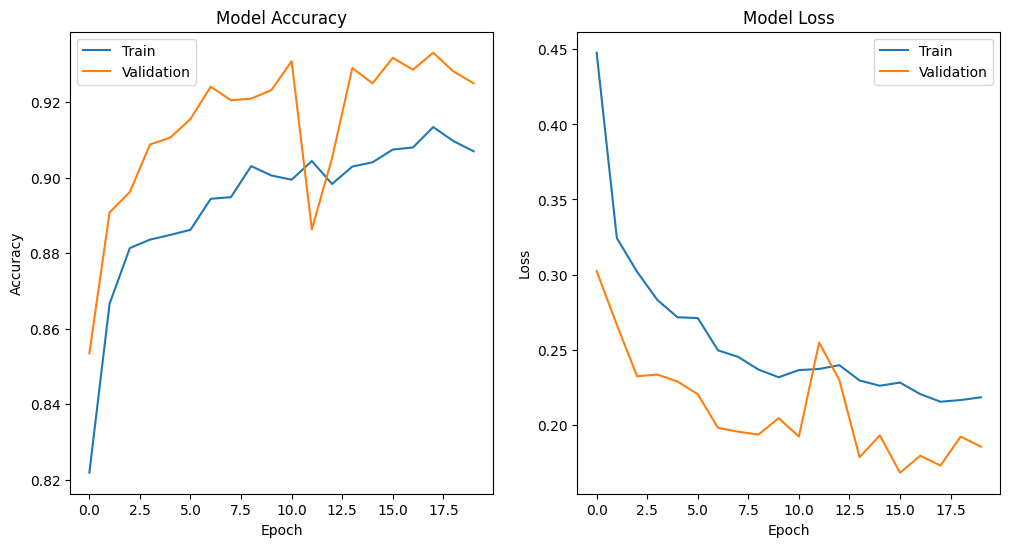

In [29]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of model.fit()
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.show()

# Plot the metrics
plot_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


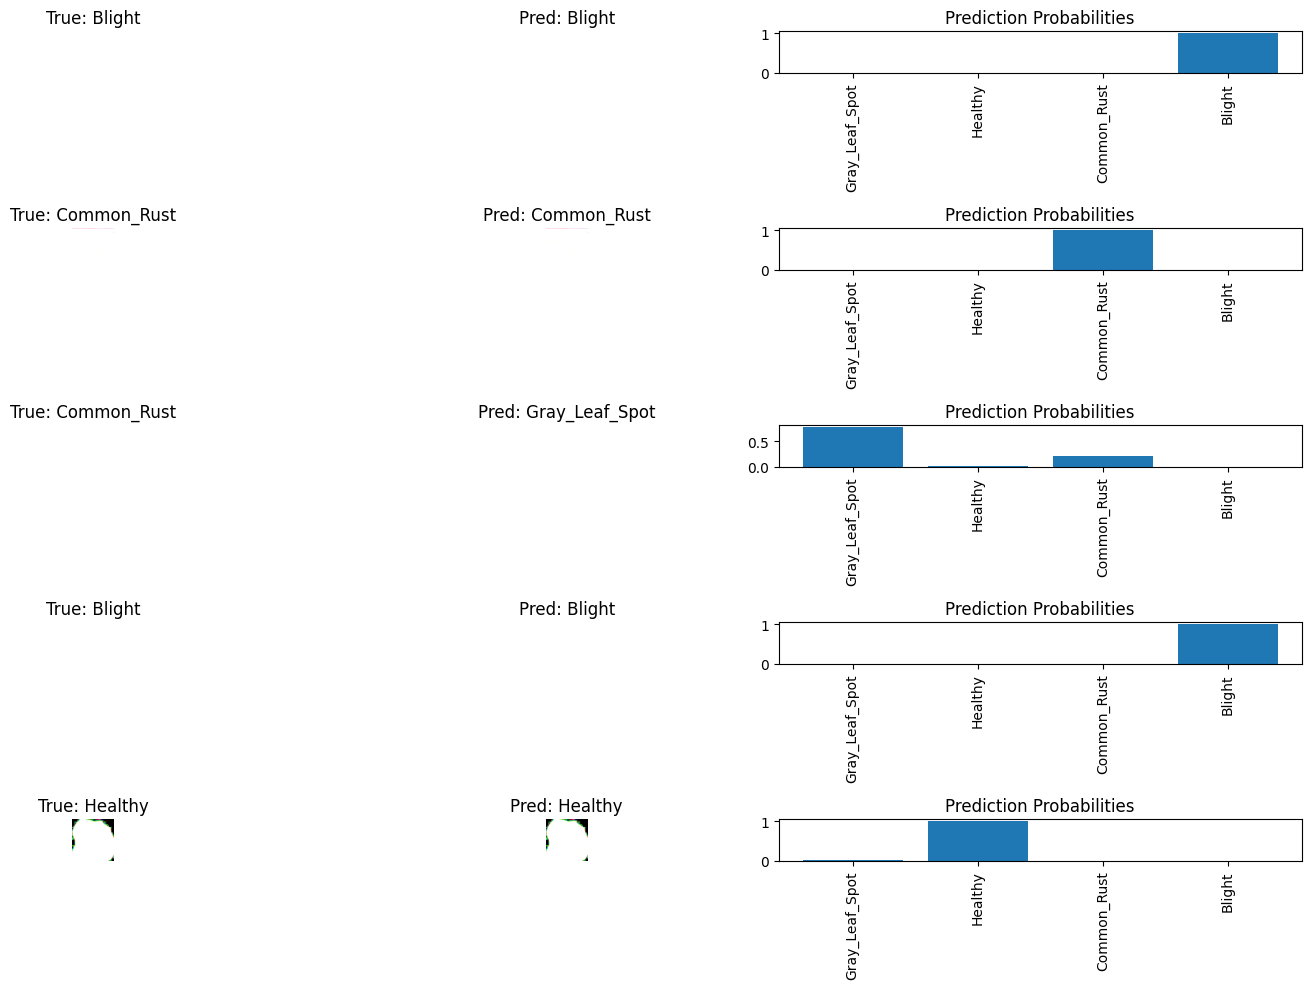

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot random predictions
def plot_random_predictions(dataset, model, class_names, num_samples=5):
    # Get a batch of images and labels
    images, labels = next(iter(dataset))

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert labels to original class names
    labels = np.array([class_names[label] for label in labels])
    predicted_labels = np.array([class_names[label] for label in predicted_labels])

    # Plot random samples
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {labels[idx]}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(images[idx])
        plt.title(f"Pred: {predicted_labels[idx]}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.bar(range(len(class_names)), predictions[idx])
        plt.title("Prediction Probabilities")
        plt.xticks(range(len(class_names)), class_names, rotation=90)

    plt.tight_layout()
    plt.show()

# Plot random predictions
plot_random_predictions(test_dataset, model, class_names)


In [31]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Print the classification report
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 

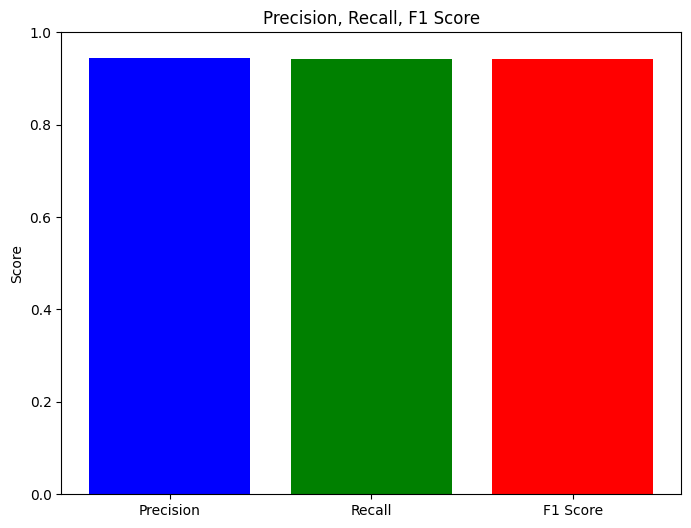

In [32]:
def plot_metrics_bar(precision, recall, f1):
    metrics = {'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    names = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(8, 6))
    plt.bar(names, values, color=['blue', 'green', 'red'])
    plt.ylim([0, 1])
    plt.title('Precision, Recall, F1 Score')
    plt.ylabel('Score')
    plt.show()

# Plot the metrics
plot_metrics_bar(precision, recall, f1)


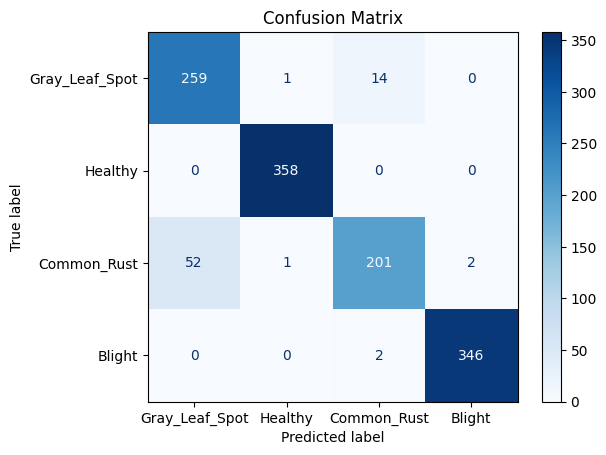

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [34]:
def print_metrics_summary(precision, recall, f1):
    print("\n--- Performance Metrics Summary ---\n")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    print("----------------------------------\n")

# Print the metrics summary
print_metrics_summary(precision, recall, f1)



--- Performance Metrics Summary ---

Precision: 0.9444
Recall: 0.9417
F1 Score: 0.9411

----------------------------------

